In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import pandas as pd


In [2]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size

data = []
labels = []
INIT_LR = 1e-3
EPOCHS = 25

BS = 8
# read COVID-19 PA X-ray images

df = pd.read_csv("metadata.csv")
df = df[['finding', 'view', 'modality', 'filename']] #only extra three columns' information
df = df[df.modality.isin(['X-ray'])] #only keep X-ray images
df = df[df.view.isin(['PA'])] #only keep PA images
df = df[df.finding.isin(['COVID-19'])] #only keep COVID-19 images
df_name = df[['filename']]
df_name.reset_index(drop=True)


,filename
0,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...
1,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...
2,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...
3,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...
4,nejmc2001573_f1a.jpeg
...,...
94,1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf...
95,1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf...
96,1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf...
97,covid-19-pneumonia-evolution-over-a-week-1-day...


In [3]:
# put all COVID-19 into the data 

for i in df_name.filename:
    b = '.\\images'
    c = b + '\\' + i
    img = cv2.imread(c) # read the image  and change to gray image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    #update the images and labels, COVID-19==1
    data.append(img)
    labels.append(1)
# put all normal X-ray images into the data 

normallist = os.listdir('./normal/')

for i in normallist:
    b = '.\\normal'
    c = b + '\\' + i
    img = cv2.imread(c) # read the image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    #update the images and labels, COVID-19==1
    data.append(img)
    labels.append(0) 


In [4]:
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]

data = np.array(data) /255.0

labels = np.array(labels)
# perfor one-hot encoding on the label, like: [0., 1.]

lb = LabelBinarizer()
labels = lb.fit_transform(labels)

labels = to_categorical(labels)
# contruct train and test dataset

(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)


In [5]:
# initialize the training data augmentation object

trainAug = ImageDataGenerator(rotation_range=15, fill_mode="nearest")
# load the VGG16 network, ensuring the head FC layer sets are left off

baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on the top 
# of the base model 

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)

headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model 

model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# not be updated during the first training process

for layer in baseModel.layers:
    layer.trainable = False


In [6]:
# compile our model

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR/EPOCHS)

model.compile(loss="binary_crossentropy", optimizer=opt, metrics=['accuracy'])
# train the head of the network

print("[INFO] training head...")

H = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=BS), 
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY), 
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)


[INFO] compiling model...
[INFO] training head...
Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 19 steps, validate on 40 samples
Epoch 1/25
19/19 [==============================] - 12s 611ms/step - loss: 0.6169 - accuracy: 0.6424 - val_loss: 0.4138 - val_accuracy: 0.9500
Epoch 2/25
19/19 [==============================] - 5s 252ms/step - loss: 0.4125 - accuracy: 0.8477 - val_loss: 0.3150 - val_accuracy: 0.9500
Epoch 3/25
19/19 [==============================] - 5s 253ms/step - loss: 0.3225 - accuracy: 0.9205 - val_loss: 0.2354 - val_accuracy: 0.9750
Epoch 4/25
19/19 [==============================] - 5s 253ms/step - loss: 0.2675 - accuracy: 0.9338 - val_loss: 0.1797 - val_accuracy: 1.0000
Epoch 5/25
19/19 [==============================] - 5s 254ms/step - loss: 0.2149 - accuracy: 0.9603 - val_loss: 0.1658 - val_accuracy: 0.9500
Epoch 6/25
19/19 [==============================] - 5s 252ms/step - loss: 0.1949 - accuracy: 0.

In [7]:
#### evaluate our model
# # make predictions on the testing set

print("[INFO] evaluating network...")  

predIdxs = model.predict(testX, batch_size=BS)
# for each image in the test set, we need to find the index 
# of the label with corresponding largest predicted probability

predIdxs = np.argmax(predIdxs, axis=1)
# show the formatted classification report

print(classification_report(testY.argmax(axis=1), predIdxs))


[INFO] evaluating network...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



In [8]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity

cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity

print(cm)
print("acc: {:.6f}".format(acc))
print("sensitivity: {:.6f}".format(sensitivity))
print("specificity: {:.6f}".format(specificity))


[[20  0]
 [ 0 20]]
acc: 1.000000
sensitivity: 1.000000
specificity: 1.000000


[INFO] saving COVID-19 detector model...


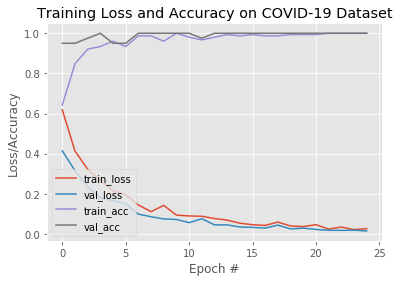

In [9]:
# plot the training loss and accuracy

N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

plt.savefig('performance.png', ppi=300)
# serialize the model to disk

print("[INFO] saving COVID-19 detector model...")
model.save("model", save_format="h5")
